# Catboost model explained with SHAP

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
%pip install -Uqq -r requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradient 2.0.5 requires attrs<=19, but you have attrs 22.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## Process data

### Import datasets

In [3]:
from fastai.imports import *

In [4]:
df = pd.read_csv('titanic/train.csv', index_col = 'PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
y = df['Survived'].copy()

In [6]:
X = df.drop(['Survived', 'Name'], axis = 1).copy()

In [7]:
df_test = pd.read_csv('titanic/test.csv', index_col = 'PassengerId')
X_test = df_test.drop('Name', axis = 1).copy()
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,
892,3,male,34.5,0,0,330911,7.8292,NaN,Q
893,3,female,47.0,1,0,363272,7.0000,NaN,S
894,2,male,62.0,0,0,240276,9.6875,NaN,Q
895,3,male,27.0,0,0,315154,8.6625,NaN,S
896,3,female,22.0,1,1,3101298,12.2875,NaN,S


### Cleaning

In [8]:
# Fill missing columns with -999
X.fillna(-999, inplace = True)
X_test.fillna(-999, inplace = True)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                 y,
                                                 test_size = 0.2,
                                                 random_state = 42)

## Catboost modeling

### Initizalize and train model

In [10]:
%pip install -Uqq catboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
import catboost
print('catboost version: ', catboost.__version__)

catboost version:  1.0.6


In [12]:
categorical_features_indices = np.where(X.dtypes != float)[0]

In [13]:
from catboost import CatBoostClassifier, Pool, metrics, cv
from sklearn.metrics import accuracy_score

train_pool = Pool(X, y, cat_features = categorical_features_indices)

cat = CatBoostClassifier(custom_loss = [metrics.Accuracy()],
                          random_seed = 42,
                          logging_level = 'Silent')

cat.fit(train_pool)

### View insights based on the train model

In [14]:
cv_params = cat.get_params()
cv_params.update({
    'loss_function': metrics.Logloss()
})
cv_data = cv(Pool(X, y, cat_features = categorical_features_indices),
            cv_params)

In [15]:
np.max(cv_data['test-Accuracy-mean'])

0.8338945005611672

In [16]:
feature_importances = cat.get_feature_importance(train_pool)
feature_names = X.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse = True):
    print('{}: {}'.format(name, score))

Sex: 25.60821888167032
Ticket: 18.57844891909078
Pclass: 12.344953433318327
Age: 10.3638125501517
SibSp: 7.436047061771068
Parch: 7.144246590871276
Cabin: 6.802311633819684
Embarked: 5.932812958742824
Fare: 5.789147970563915


### Make prediction

In [17]:
predictions = cat.predict(X_test)

In [18]:
subm = pd.DataFrame(predictions,
                   index = X_test.index,
                   columns = ['Survived'])

In [19]:
subm.to_csv('subm.csv')
!head subm.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1


In [20]:
from kaggle import api
api.competition_submit_cli('subm.csv',
                          'catboost fillna = -999 train val with name',
                          'titanic')

100%|██████████| 2.77k/2.77k [00:00<00:00, 5.46kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster

## Explain the feature importance in the model

### Partial dependence plot

In [19]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt

In [22]:
model = cat

In [23]:
def importance(model: object = model,
               X: object = X_test,
               y: object = y_test,
               scoring: string = 'roc_auc',
               repeats: int = 10,
               n_jobs: int = -1):
    '''
    Calculate and plot the permutation importance of features.
    Required dependencies:
    from sklearn.inspection import plot_partial_dependence, permutation_importance
    import matplotlib.pyplot as plt
    '''
    # Calculate permutation importance
    r = permutation_importance(estimator = model,
                              X = X,
                              y = y,
                              scoring = scoring,
                              n_repeats = repeats,
                              n_jobs = n_jobs)
    
    # Plot the result
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    sort_idx = r.importances_mean.argsort()
    ax.boxplot(r.importances[sort_idx].T, labels = [X.columns[i] for i in sort_idx], vert = False)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(20)
    fig.tight_layout()

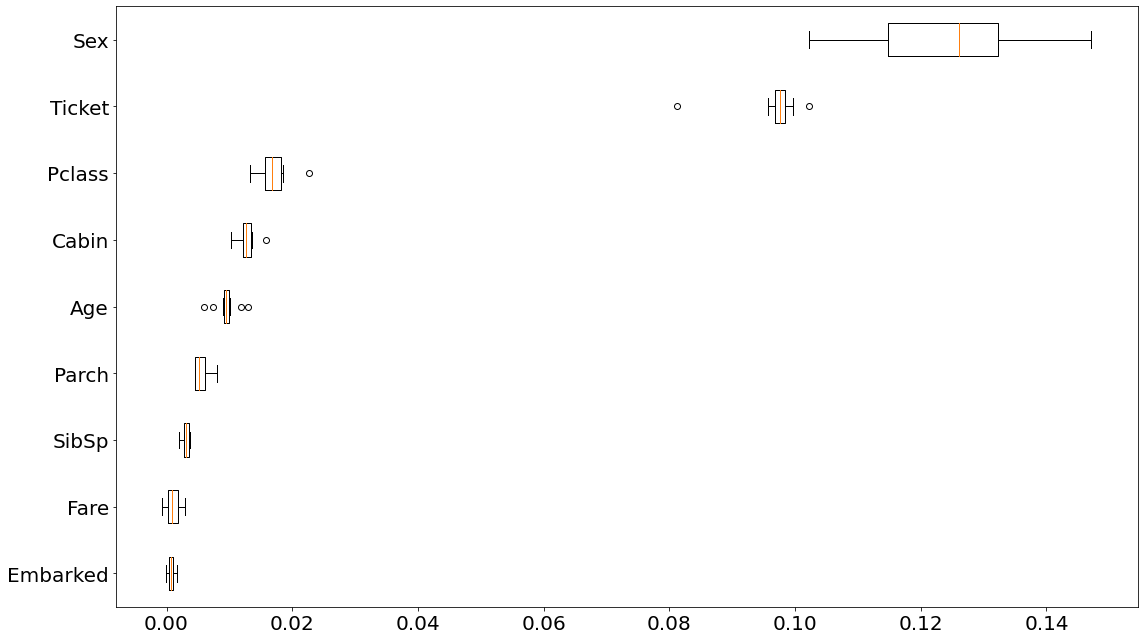

In [25]:
importance(model = cat, X = X, y = y)

### SHAP

In [21]:
import shap
print('shap version: ', shap.__version__)

shap version:  0.41.0


In [22]:
shap.initjs()

#### Tree explainer class

In [23]:
explainer = shap.TreeExplainer(cat)
shap_values = explainer.shap_values(X)

In [24]:
shap.force_plot(explainer.expected_value, shap_values, X)

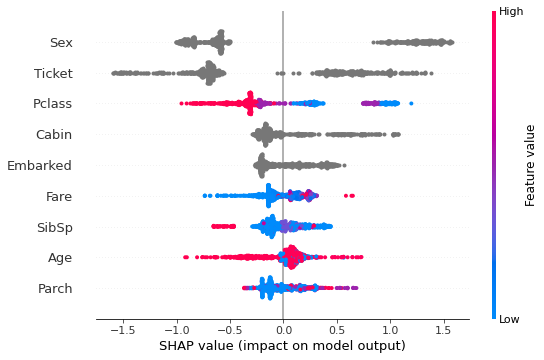

In [26]:
shap.summary_plot(shap_values, X)

In [ ]:
shap.dependence_plot("Age", shap_values, X)

#### Explainer class

In [33]:
explainer = shap.Explainer(cat)
shap_values = explainer(X)

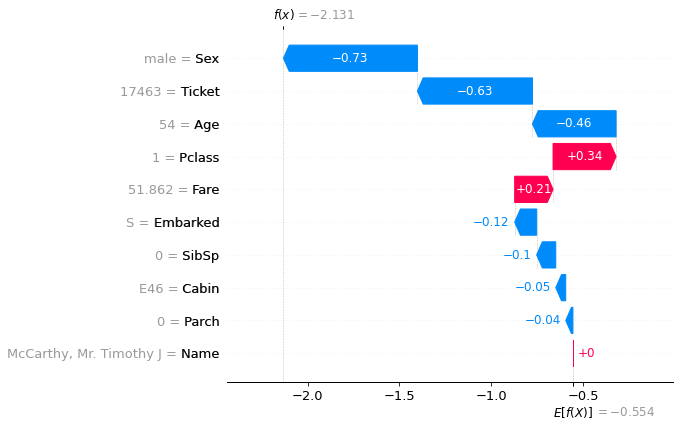

In [36]:
shap.plots.waterfall(shap_values[6])

In [37]:
shap.plots.force(shap_values)

#### Kernel Explainer class

In [55]:
%%capture
explainer = shap.KernelExplainer(cat.predict_proba, shap.sample(X), link = "identity")
shap_values = explainer.shap_values(X, nsamples = 10)

In [56]:
shap.force_plot(base_value = explainer.expected_value[1],
               shap_values = shap_values[1],
               features = X.columns.to_list())

In [57]:
# print(shap_values.shape)
shap.force_plot(explainer.expected_value[0], shap_values[0], X, link = 'identity')

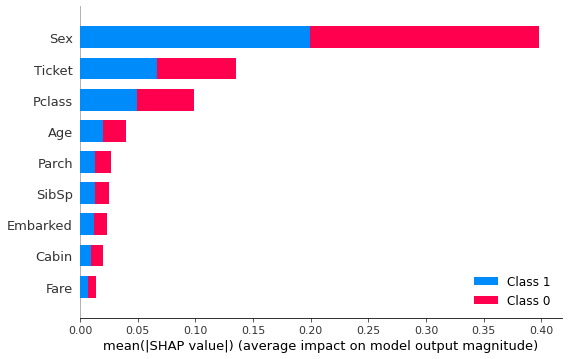

In [46]:
shap.summary_plot(shap_values = shap_values,
                 features = X.columns.to_list())